In [1]:
import numpy as np
import pandas as pd
import cobra
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba
from IPython.display import display, Markdown
import pickleshare

#For PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

#For UMAP
import umap
from sklearn.preprocessing import StandardScaler

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = read_sbml_model('iCHO2441_221-107_producing.xml')
model

Set parameter Username
Set parameter LicenseID to value 2611274
Academic license - for non-commercial use only - expires 2026-01-17


Name,iCHO2441_221107_producing
Memory address,181082ac860
Number of metabolites,4174
Number of reactions,6337
Number of genes,2441
Number of groups,15
Objective expression,1.0*biomass_cho_prod - 1.0*biomass_cho_prod_reverse_1b5b7
Compartments,"cytosol, lysosome, mitochondria, endoplasmicReticulum, nucleus, extracellularSpace, peroxisome, golgiApparatus, secretoryVesicle"


In [27]:
bounds_df = pd.read_csv('bounds_df.csv')

for index, row in bounds_df.iterrows():
    reaction = model.reactions.get_by_id(row['reaction'])
    reaction.lower_bound = row['lower bound']
    reaction.upper_bound = row['upper bound']

In [28]:
mismatches = []
for index, row in bounds_df.iterrows():
    reaction = model.reactions.get_by_id(row['reaction'])
    if reaction.lower_bound != row['lower bound'] or reaction.upper_bound != row['upper bound']:
        mismatches.append((row['reaction'], reaction.lower_bound, reaction.upper_bound, row['lower bound'], row['upper bound']))

# Print mismatches if any
if mismatches:
    print(f"{len(mismatches)} reactions have incorrect bounds:")
    for rxn, lb_model, ub_model, lb_csv, ub_csv in mismatches[:10]:  # Show first 10 mismatches
        print(f"{rxn}: Model({lb_model}, {ub_model}) != CSV({lb_csv}, {ub_csv})")
else:
    print("All reaction bounds were correctly updated!")

All reaction bounds were correctly updated!


In [29]:
#remove non-negative bound on lactate and ammonia exchange reactions

model.reactions.get_by_id('EX_lac_L(e)').lower_bound = -1000
model.reactions.get_by_id('EX_nh4(e)').lower_bound = -1000

In [30]:
print('the current model objective function is:',model.objective)
solution = model.optimize()

the current model objective function is: Maximize
1.0*biomass_cho_prod - 1.0*biomass_cho_prod_reverse_1b5b7


In [31]:
igg = model.reactions.get_by_id('igg_formation')
lactate = model.reactions.get_by_id('EX_lac_L(e)')
glutamine = model.reactions.get_by_id('EX_gln_L(e)')
glucose = model.reactions.get_by_id('EX_glc(e)')
ammonia = model.reactions.get_by_id('EX_nh4(e)')
biomass = model.reactions.get_by_id('biomass_cho_prod')

In [32]:
with model:
    model.objective = model.problem.Objective(igg.flux_expression, direction="min")
    print(model.objective)
    igg_solution = model.optimize()
    igg_growth = igg_solution.fluxes['biomass_cho_prod']
    igg_summary = model.summary(igg_solution)
    igg_uptakes = igg_summary.uptake_flux
    igg_secretions = igg_summary.secretion_flux
    igg_p_solution = pfba(model)
    igg_p_summary = model.summary(igg_p_solution)
    igg_p_uptakes = igg_p_summary.uptake_flux
    igg_p_secretions = igg_p_summary.secretion_flux
    igg_l_solution = loopless_solution(model)
    igg_l_summary = model.summary(igg_l_solution)
    igg_l_uptakes = igg_l_summary.uptake_flux
    igg_l_secretions = igg_l_summary.secretion_flux
    igg_l_growth = igg_l_solution.fluxes['biomass_cho_prod']
    igg_p_growth = igg_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### IgG"))
display(igg_uptakes)
non_zero_igg_secretions = igg_secretions[igg_secretions['flux'] != 0]
non_zero_igg_p_secretions = igg_p_secretions[igg_p_secretions['flux'] != 0]
non_zero_igg_l_secretions = igg_l_secretions[igg_l_secretions['flux'] != 0]
display(non_zero_igg_secretions)

Minimize
1.0*igg_formation - 1.0*igg_formation_reverse_7519c


### IgG

,flux,reaction,metabolite
EX_arg_L(e),0.000628,EX_arg_L(e),arg_L[e]
EX_asn_L(e),0.000531,EX_asn_L(e),asn_L[e]
EX_asp_L(e),0.002572,EX_asp_L(e),asp_L[e]
EX_chol(e),0.000162,EX_chol(e),chol[e]
EX_cys_L(e),0.000211,EX_cys_L(e),cys_L[e]
EX_fol(e),0.000457,EX_fol(e),fol[e]
EX_glc(e),0.055407,EX_glc(e),glc_D[e]
EX_gln_L(e),0.005028,EX_gln_L(e),gln_L[e]
EX_his_L(e),0.000245,EX_his_L(e),his_L[e]
EX_hxan(e),0.000212,EX_hxan(e),hxan[e]


,flux,reaction,metabolite
EX_4abut(e),-0.000871,EX_4abut(e),4abut[e]
EX_5mthf(e),-0.000457,EX_5mthf(e),5mthf[e]
EX_acald(e),-0.000711,EX_acald(e),acald[e]
EX_ala_D(e),-0.002944,EX_ala_D(e),ala_D[e]
EX_co2(e),-0.005571,EX_co2(e),co2[e]
EX_for(e),-0.000220,EX_for(e),for[e]
EX_galt(e),-0.011145,EX_galt(e),galt[e]
EX_h(e),-0.071636,EX_h(e),h[e]
EX_h2o(e),-0.090069,EX_h2o(e),h2o[e]
EX_lac_D(e),-0.000107,EX_lac_D(e),lac_D[e]


In [33]:
with model:
    model.objective = model.problem.Objective(lactate.flux_expression, direction="max")
    print(model.objective)
    lac_solution = model.optimize()
    lac_growth = lac_solution.fluxes['biomass_cho_prod']
    lac_summary = model.summary()
    lac_uptakes = lac_summary.uptake_flux
    lac_secretions = lac_summary.secretion_flux
    lac_p_solution = pfba(model)
    lac_p_summary = model.summary(lac_p_solution)
    lac_p_uptakes = lac_p_summary.uptake_flux
    lac_p_secretions = lac_p_summary.secretion_flux
    lac_l_solution = loopless_solution(model)
    lac_l_summary = model.summary(lac_l_solution)
    lac_l_uptakes = lac_l_summary.uptake_flux
    lac_l_secretions = lac_l_summary.secretion_flux
    lac_l_growth = lac_l_solution.fluxes['biomass_cho_prod']
    lac_p_growth = lac_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### Lactate"))
display(lac_uptakes)
non_zero_lac_secretions = lac_secretions[lac_secretions['flux'] != 0]
non_zero_lac_p_secretions = lac_p_secretions[lac_p_secretions['flux'] != 0]
non_zero_lac_l_secretions = lac_l_secretions[lac_l_secretions['flux'] != 0]
display(non_zero_lac_secretions)

Maximize
1.0*EX_lac_L(e) - 1.0*EX_lac_L(e)_reverse_32b05


### Lactate

,flux,reaction,metabolite
EX_arg_L(e),0.019780,EX_arg_L(e),arg_L[e]
EX_fol(e),0.000457,EX_fol(e),fol[e]
EX_glc(e),0.198352,EX_glc(e),glc_D[e]
EX_gln_L(e),0.067033,EX_gln_L(e),gln_L[e]
EX_his_L(e),0.003297,EX_his_L(e),his_L[e]
EX_hxan(e),0.006195,EX_hxan(e),hxan[e]
EX_ile_L(e),0.008782,EX_ile_L(e),ile_L[e]
EX_leu_L(e),0.002144,EX_leu_L(e),leu_L[e]
EX_lys_L(e),0.003771,EX_lys_L(e),lys_L[e]
EX_o2(e),0.207632,EX_o2(e),o2[e]


,flux,reaction,metabolite
EX_4abut(e),-0.052789,EX_4abut(e),4abut[e]
EX_5mthf(e),-0.000457,EX_5mthf(e),5mthf[e]
EX_acald(e),-0.001956,EX_acald(e),acald[e]
EX_ala_B(e),-0.002443,EX_ala_B(e),ala_B[e]
EX_ala_L(e),-0.015431,EX_ala_L(e),ala_L[e]
EX_co2(e),-0.129240,EX_co2(e),co2[e]
EX_for(e),-0.004077,EX_for(e),for[e]
EX_h(e),-0.373838,EX_h(e),h[e]
EX_hco3(e),-0.006398,EX_hco3(e),hco3[e]
EX_lac_D(e),-0.000107,EX_lac_D(e),lac_D[e]


In [34]:
with model:
    model.objective = model.problem.Objective(glutamine.flux_expression, direction="min")
    print(model.objective)
    gln_solution = model.optimize()
    gln_growth = gln_solution.fluxes['biomass_cho_prod']
    gln_summary = model.summary()
    gln_uptakes = gln_summary.uptake_flux
    gln_secretions = gln_summary.secretion_flux
    gln_p_solution = pfba(model)
    gln_p_summary = model.summary(gln_p_solution)
    gln_p_uptakes = gln_p_summary.uptake_flux
    gln_p_secretions = gln_p_summary.secretion_flux
    gln_l_solution = loopless_solution(model)
    gln_l_summary = model.summary(gln_l_solution)
    gln_l_uptakes = gln_l_summary.uptake_flux
    gln_l_secretions = gln_l_summary.secretion_flux
    gln_l_growth = gln_l_solution.fluxes['biomass_cho_prod']
    gln_p_growth = gln_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### Glutamine"))
display(gln_uptakes)
non_zero_gln_secretions = gln_secretions[gln_secretions['flux'] != 0]
non_zero_gln_p_secretions = gln_p_secretions[gln_p_secretions['flux'] != 0]
non_zero_gln_l_secretions = gln_l_secretions[gln_l_secretions['flux'] != 0]
display(non_zero_gln_secretions)

Minimize
1.0*EX_gln_L(e) - 1.0*EX_gln_L(e)_reverse_75782


### Glutamine

,flux,reaction,metabolite
EX_gln_L(e),0.067033,EX_gln_L(e),gln_L[e]
EX_h2o(e),0.067033,EX_h2o(e),h2o[e]


,flux,reaction,metabolite
EX_glu_L(e),-0.067033,EX_glu_L(e),glu_L[e]
EX_nh4(e),-0.067033,EX_nh4(e),nh4[e]


In [55]:
with model:
    model.objective = model.problem.Objective(-glucose.flux_expression, direction="max")
    print(model.objective)
    glc_solution = model.optimize()
    glc_growth = glc_solution.fluxes['biomass_cho_prod']
    glc_igg = glc_solution.fluxes['igg_formation']
    glc_summary = model.summary()
    glc_uptakes = glc_summary.uptake_flux
    glc_secretions = glc_summary.secretion_flux
    glc_p_solution = pfba(model)
    glc_p_summary = model.summary(glc_p_solution)
    glc_p_uptakes = glc_p_summary.uptake_flux
    glc_p_secretions = glc_p_summary.secretion_flux
    glc_l_solution = loopless_solution(model)
    glc_l_summary = model.summary(glc_l_solution)
    glc_l_uptakes = glc_l_summary.uptake_flux
    glc_l_secretions = glc_l_summary.secretion_flux
    glc_l_growth = glc_l_solution.fluxes['biomass_cho_prod']
    glc_p_growth = glc_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### Glucose"))
display(glc_summary)
non_zero_glc_secretions = glc_secretions[glc_secretions['flux'] != 0]
non_zero_glc_p_secretions = glc_p_secretions[glc_p_secretions['flux'] != 0]
non_zero_glc_l_secretions = glc_l_secretions[glc_l_secretions['flux'] != 0]

Maximize
-1.0*EX_glc(e) + 1.0*EX_glc(e)_reverse_bcf3e


### Glucose

Metabolite,Reaction,Flux,C-Number,C-Flux
glc_D[e],EX_glc(e),0.1984,6,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o[e],EX_h2o(e),-0.09918,0,0.00%
isomal[e],EX_isomal(e),-0.09918,12,100.00%


In [36]:
with model:
    model.objective = model.problem.Objective(ammonia.flux_expression, direction="max")
    print(model.objective)
    nh4_solution = model.optimize()
    nh4_growth = nh4_solution.fluxes['biomass_cho_prod']
    nh4_summary = model.summary()
    nh4_uptakes = nh4_summary.uptake_flux
    nh4_secretions = nh4_summary.secretion_flux
    nh4_p_solution = pfba(model)
    nh4_p_summary = model.summary(nh4_p_solution)
    nh4_p_uptakes = nh4_p_summary.uptake_flux
    nh4_p_secretions = nh4_p_summary.secretion_flux
    nh4_l_solution = loopless_solution(model)
    nh4_l_summary = model.summary(nh4_l_solution)
    nh4_l_uptakes = nh4_l_summary.uptake_flux
    nh4_l_secretions = nh4_l_summary.secretion_flux
    nh4_l_growth = nh4_l_solution.fluxes['biomass_cho_prod']
    nh4_p_growth = nh4_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### Ammonia"))
display(nh4_uptakes)
non_zero_nh4_secretions = nh4_secretions[nh4_secretions['flux'] != 0]
non_zero_nh4_p_secretions = nh4_p_secretions[nh4_p_secretions['flux'] != 0]
non_zero_nh4_l_secretions = nh4_l_secretions[nh4_l_secretions['flux'] != 0]
display(non_zero_nh4_secretions)

Maximize
1.0*EX_nh4(e) - 1.0*EX_nh4(e)_reverse_db85a


### Ammonia

,flux,reaction,metabolite
EX_arg_L(e),0.019780,EX_arg_L(e),arg_L[e]
EX_asn_L(e),0.040385,EX_asn_L(e),asn_L[e]
EX_asp_L(e),0.009341,EX_asp_L(e),asp_L[e]
EX_chol(e),0.008152,EX_chol(e),chol[e]
EX_cys_L(e),0.005220,EX_cys_L(e),cys_L[e]
EX_glc(e),0.050504,EX_glc(e),glc_D[e]
EX_gln_L(e),0.067033,EX_gln_L(e),gln_L[e]
EX_h2o(e),0.068036,EX_h2o(e),h2o[e]
EX_his_L(e),0.003297,EX_his_L(e),his_L[e]
EX_ile_L(e),0.010165,EX_ile_L(e),ile_L[e]


,flux,reaction,metabolite
EX_2hb(e),-0.005260,EX_2hb(e),2hb[e]
EX_2hyoxplac(e),-0.005196,EX_2hyoxplac(e),2hyoxplac[e]
EX_34dhoxpeg(e),-0.001251,EX_34dhoxpeg(e),34dhoxpeg[e]
EX_3mob(e),-0.012077,EX_3mob(e),3mob[e]
EX_3mop(e),-0.010176,EX_3mop(e),3mop[e]
EX_3mox4hoxm(e),-0.007105,EX_3mox4hoxm(e),3mox4hoxm[e]
EX_4mop(e),-0.014854,EX_4mop(e),4mop[e]
EX_acald(e),-0.002882,EX_acald(e),acald[e]
EX_akg(e),-0.064778,EX_akg(e),akg[e]
EX_co2(e),-0.030504,EX_co2(e),co2[e]


In [37]:
with model:
    model.objective = model.problem.Objective(biomass.flux_expression, direction="min")
    print(model.objective)
    biomass_solution = model.optimize()
    biomass_growth = biomass_solution.fluxes['biomass_cho_prod']
    biomass_summary = model.summary()
    biomass_uptakes = biomass_summary.uptake_flux
    biomass_secretions = biomass_summary.secretion_flux
    biomass_p_solution = pfba(model)
    biomass_p_summary = model.summary(biomass_p_solution)
    biomass_p_uptakes = biomass_p_summary.uptake_flux
    biomass_p_secretions = biomass_p_summary.secretion_flux
    biomass_l_solution = loopless_solution(model)
    biomass_l_summary = model.summary(biomass_l_solution)
    biomass_l_uptakes = biomass_l_summary.uptake_flux
    biomass_l_secretions = biomass_l_summary.secretion_flux
    biomass_l_growth = biomass_l_solution.fluxes['biomass_cho_prod']
    biomass_p_growth = biomass_p_solution.fluxes['biomass_cho_prod']

display(Markdown("### Biomass"))
display(biomass_uptakes)
non_zero_biomass_secretions = biomass_secretions[biomass_secretions['flux'] != 0]
non_zero_biomass_p_secretions = biomass_p_secretions[biomass_p_secretions['flux'] != 0]
non_zero_biomass_l_secretions = biomass_l_secretions[biomass_l_secretions['flux'] != 0]
display(non_zero_biomass_secretions)

Minimize
1.0*biomass_cho_prod - 1.0*biomass_cho_prod_reverse_1b5b7


### Biomass

,flux,reaction,metabolite


,flux,reaction,metabolite


In [38]:
print('growth under growth optimisation:',biomass_growth)
print('growth under loopless biomass optimisation:',biomass_l_growth)
print('growth under parsimonious biomass optimisation:',biomass_p_growth)
print('growth under igg optimisation:',igg_growth)
print('growth under loopless igg optimisation:',igg_l_growth)
print('growth under parsimonious igg optimisation:',igg_p_growth)
print('growth under lac optimisation:',lac_growth)
print('growth under loopless lac optimisation:',lac_l_growth)
print('growth under parsimonious lac optimisation:',lac_p_growth)
print('growth under glutamine optimisation:',gln_growth)
print('growth under loopless glutamine optimisation:',gln_l_growth)
print('growth under parsimonious glutamine optimisation:',gln_p_growth)
print('growth under glucose optimisation:',glc_growth)
print('growth under loopless glucose optimisation:',glc_l_growth)
print('growth under parsimonious glucose optimisation:',glc_p_growth)
print('growth under ammonia optimisation:',nh4_growth)
print('growth under loopless ammonia optimisation:',nh4_l_growth)
print('growth under parsimonious ammonia optimisation:',nh4_p_growth)

growth under growth optimisation: 0.0
growth under loopless biomass optimisation: 0.0
growth under parsimonious biomass optimisation: 0.0
growth under igg optimisation: 0.0020123131513649
growth under loopless igg optimisation: 0.0
growth under parsimonious igg optimisation: 0.0
growth under lac optimisation: 0.0
growth under loopless lac optimisation: 0.0
growth under parsimonious lac optimisation: 0.0
growth under glutamine optimisation: 0.0
growth under loopless glutamine optimisation: 0.0
growth under parsimonious glutamine optimisation: 0.0
growth under glucose optimisation: 0.0
growth under loopless glucose optimisation: 0.0
growth under parsimonious glucose optimisation: 0.0
growth under ammonia optimisation: 0.0
growth under loopless ammonia optimisation: 0.0
growth under parsimonious ammonia optimisation: 0.0


In [39]:
all_uptakes = set(biomass_uptakes['metabolite']) | set(biomass_l_uptakes['metabolite']) | set(biomass_p_uptakes['metabolite']) | set(igg_uptakes['metabolite']) | set(igg_l_uptakes['metabolite']) | set(igg_p_uptakes['metabolite']) | set(lac_uptakes['metabolite']) | set(lac_l_uptakes['metabolite']) | set(lac_p_uptakes['metabolite']) | set(gln_uptakes['metabolite']) | set(gln_l_uptakes['metabolite']) | set(gln_p_uptakes['metabolite']) | set(glc_uptakes['metabolite']) | set(glc_l_uptakes['metabolite']) | set(glc_p_uptakes['metabolite']) | set(nh4_uptakes['metabolite']) | set(nh4_l_uptakes['metabolite']) | set(nh4_p_uptakes['metabolite']) 

uptakes_df = pd.DataFrame({'id': list(all_uptakes)})
biomass_uptakes_list = []
biomass_l_uptakes_list = []
biomass_p_uptakes_list = []
igg_uptakes_list = []
igg_l_uptakes_list = []
igg_p_uptakes_list = []
lac_uptakes_list = []
lac_l_uptakes_list = []
lac_p_uptakes_list = []
gln_uptakes_list = []
gln_l_uptakes_list = []
gln_p_uptakes_list = []
glc_uptakes_list = []
glc_l_uptakes_list = []
glc_p_uptakes_list = []
nh4_uptakes_list = []
nh4_l_uptakes_list = []
nh4_p_uptakes_list = []
reactions_list = []
metabolite_names = []

# Iterate over all metabolites
for met in all_uptakes:
    biomass_flux = '-'
    biomass_l_flux = '-'
    biomass_p_flux = '-'
    igg_flux = '-'
    igg_l_flux = '-'
    igg_p_flux = '-'
    lac_flux = '-'
    lac_l_flux = '-'
    lac_p_flux = '-'
    gln_flux = '-'
    gln_l_flux = '-'
    gln_p_flux = '-'
    glc_flux = '-'
    glc_l_flux = '-'
    glc_p_flux = '-'
    nh4_flux = '-'
    nh4_l_flux = '-'
    nh4_p_flux = '-'
    reaction = '-'
    
    if met in biomass_uptakes['metabolite'].tolist():
        biomass_flux = biomass_uptakes.loc[biomass_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = biomass_uptakes.loc[biomass_uptakes['metabolite'] == met, 'reaction'].values[0]
        
    if met in biomass_l_uptakes['metabolite'].tolist():
        biomass_l_flux = biomass_l_uptakes.loc[biomass_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = biomass_l_uptakes.loc[biomass_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in biomass_p_uptakes['metabolite'].tolist():
        biomass_p_flux = biomass_p_uptakes.loc[biomass_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = biomass_p_uptakes.loc[biomass_p_uptakes['metabolite'] == met, 'reaction'].values[0]
    
    if met in igg_uptakes['metabolite'].tolist():
        igg_flux = igg_uptakes.loc[igg_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = igg_uptakes.loc[igg_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in igg_l_uptakes['metabolite'].tolist():
        igg_l_flux = igg_l_uptakes.loc[igg_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = igg_l_uptakes.loc[igg_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in igg_p_uptakes['metabolite'].tolist():
        igg_p_flux = igg_p_uptakes.loc[igg_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = igg_p_uptakes.loc[igg_p_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in lac_uptakes['metabolite'].tolist():
        lac_flux = lac_uptakes.loc[lac_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = lac_uptakes.loc[lac_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in lac_l_uptakes['metabolite'].tolist():
        lac_l_flux = lac_l_uptakes.loc[lac_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = lac_l_uptakes.loc[lac_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in lac_p_uptakes['metabolite'].tolist():
        lac_p_flux = lac_p_uptakes.loc[lac_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = lac_p_uptakes.loc[lac_p_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in gln_uptakes['metabolite'].tolist():
        gln_flux = gln_uptakes.loc[gln_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = gln_uptakes.loc[gln_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in gln_l_uptakes['metabolite'].tolist():
        gln_l_flux = gln_l_uptakes.loc[gln_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = gln_l_uptakes.loc[gln_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in gln_p_uptakes['metabolite'].tolist():
        gln_p_flux = gln_p_uptakes.loc[gln_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = gln_p_uptakes.loc[gln_p_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in glc_uptakes['metabolite'].tolist():
        glc_flux = glc_uptakes.loc[glc_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = glc_uptakes.loc[glc_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in glc_l_uptakes['metabolite'].tolist():
        glc_l_flux = glc_l_uptakes.loc[glc_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = glc_l_uptakes.loc[glc_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in glc_p_uptakes['metabolite'].tolist():
        glc_p_flux = glc_p_uptakes.loc[glc_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = glc_p_uptakes.loc[glc_p_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in nh4_uptakes['metabolite'].tolist():
        nh4_flux = nh4_uptakes.loc[nh4_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_uptakes.loc[nh4_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in nh4_l_uptakes['metabolite'].tolist():
        nh4_l_flux = nh4_l_uptakes.loc[nh4_l_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_l_uptakes.loc[nh4_l_uptakes['metabolite'] == met, 'reaction'].values[0]

    if met in nh4_p_uptakes['metabolite'].tolist():
        nh4_p_flux = nh4_p_uptakes.loc[nh4_p_uptakes['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_p_uptakes.loc[nh4_p_uptakes['metabolite'] == met, 'reaction'].values[0]
    
    # Append flux values to lists
    biomass_uptakes_list.append(biomass_flux)
    biomass_l_uptakes_list.append(biomass_l_flux)
    biomass_p_uptakes_list.append(biomass_p_flux)
    igg_uptakes_list.append(igg_flux)
    igg_l_uptakes_list.append(igg_l_flux)
    igg_p_uptakes_list.append(igg_p_flux)
    lac_uptakes_list.append(lac_flux)
    lac_l_uptakes_list.append(lac_l_flux)
    lac_p_uptakes_list.append(lac_p_flux)
    gln_uptakes_list.append(gln_flux)
    gln_l_uptakes_list.append(gln_l_flux)
    gln_p_uptakes_list.append(gln_p_flux)
    glc_uptakes_list.append(glc_flux)
    glc_p_uptakes_list.append(glc_p_flux)
    glc_l_uptakes_list.append(glc_l_flux)
    nh4_uptakes_list.append(nh4_flux)
    nh4_l_uptakes_list.append(nh4_l_flux)
    nh4_p_uptakes_list.append(nh4_p_flux)
    reactions_list.append(reaction)
    metabolite_names.append(model.metabolites.get_by_id(met).name)

# Add flux values to DataFrame
uptakes_df['metabolite'] = metabolite_names
uptakes_df['reaction'] = reactions_list
uptakes_df['biomass_objective flux'] = biomass_uptakes_list
uptakes_df['loopless biomass_objective flux'] = biomass_l_uptakes_list
uptakes_df['parsimonious biomass_objective flux'] = biomass_p_uptakes_list
uptakes_df['igg_objective flux'] = igg_uptakes_list
uptakes_df['loopless igg_objective flux'] = igg_l_uptakes_list
uptakes_df['parsimonious igg_objective flux'] = igg_p_uptakes_list
uptakes_df['lac_objective flux'] = lac_uptakes_list
uptakes_df['loopless lac_objective flux'] = lac_l_uptakes_list
uptakes_df['parsimonious lac_objective flux'] = lac_p_uptakes_list
uptakes_df['gln_objective flux'] = gln_uptakes_list
uptakes_df['loopless gln_objective flux'] = gln_l_uptakes_list
uptakes_df['parsimonious gln_objective flux'] = gln_p_uptakes_list
uptakes_df['glc_objective flux'] = glc_uptakes_list
uptakes_df['loopless glc_objective flux'] = glc_l_uptakes_list
uptakes_df['parsimonious glc_objective flux'] = glc_p_uptakes_list
uptakes_df['nh4_objective flux'] = nh4_uptakes_list
uptakes_df['loopless nh4_objective flux'] = nh4_l_uptakes_list
uptakes_df['parsimonious ng4_objective flux'] = nh4_p_uptakes_list

# Set metabolite as the index
uptakes_df = uptakes_df.set_index('metabolite')
uptakes_df = uptakes_df.drop('id', axis=1)

# Function to apply row colors
def highlight_rows(s):
    if s.name in ['igg[g]', 'L-glutamine', 'D-glucose']:  # Green rows
        return ['background-color: lightcoral'] * len(s)
    elif s.name in ['(S)-lactate', 'Ammonium']:  # Red rows
        return ['background-color: lightgreen'] * len(s)
    else:  # No color
        return [''] * len(s)

# Display the final DataFrame
display(Markdown("### Metabolite Uptakes (green = expected uptake, red = expected secretion)"))
display(uptakes_df.style.apply(highlight_rows, axis=1))

uptakes_df.to_csv('uptakes_2.csv', index=True)

### Metabolite Uptakes (green = expected uptake, red = expected secretion)

,reaction,biomass_objective flux,loopless biomass_objective flux,parsimonious biomass_objective flux,igg_objective flux,loopless igg_objective flux,parsimonious igg_objective flux,lac_objective flux,loopless lac_objective flux,parsimonious lac_objective flux,gln_objective flux,loopless gln_objective flux,parsimonious gln_objective flux,glc_objective flux,loopless glc_objective flux,parsimonious glc_objective flux,nh4_objective flux,loopless nh4_objective flux,parsimonious ng4_objective flux
metabolite,,,,,,,,,,,,,,,,,,,
D-glucose,EX_glc(e),-,-,-,0.055407,-,-,0.198352,0.198352,0.198352,-,-,-,0.198352,0.198352,0.198352,0.050504,0.068470,0.050504
L-phenylalanine,EX_phe_L(e),-,-,-,0.000475,-,-,-,-,-,-,-,-,-,-,-,0.006044,0.006044,0.006044
L-argininium(1+),EX_arg_L(e),-,-,-,0.000628,-,-,0.019780,0.019780,0.019780,-,-,-,-,-,-,0.019780,0.019780,0.019780
L-histidine,EX_his_L(e),-,-,-,0.000245,-,-,0.003297,0.003297,0.003297,-,-,-,-,-,-,0.003297,0.003297,0.003297
proton,EX_h(e),-,-,-,-,-,-,-,-,-,-,0.002033,-,-,-,-,-,-,-
(S)-lactate,EX_lac_L(e),-,-,-,-,-,-,-,-,-,-,0.002342,-,-,-,-,-,-,-
H2O,EX_h2o(e),-,-,-,-,-,-,-,-,-,0.067033,0.066284,0.067033,-,-,-,0.068036,0.023239,0.068036
L-serine,EX_ser_L(e),-,-,-,0.001336,-,-,-,-,-,-,0.047802,-,-,-,-,0.047802,0.047802,0.047802
Folate,EX_fol(e),-,-,-,0.000457,-,-,0.000457,-,0.000457,-,-,-,-,-,-,-,-,-


In [40]:
all_secretions = set(non_zero_biomass_secretions['metabolite']) | set(non_zero_igg_secretions['metabolite']) | set(non_zero_lac_secretions['metabolite'])| set(non_zero_gln_secretions['metabolite']) | set(non_zero_glc_secretions['metabolite']) | set(non_zero_nh4_secretions['metabolite']) | set(non_zero_biomass_l_secretions['metabolite']) | set(non_zero_biomass_p_secretions['metabolite'])| set(non_zero_igg_l_secretions['metabolite']) | set(non_zero_igg_p_secretions['metabolite']) | set(non_zero_lac_l_secretions['metabolite']) | set(non_zero_lac_p_secretions['metabolite']) | set(non_zero_gln_l_secretions['metabolite']) | set(non_zero_gln_p_secretions['metabolite'])| set(non_zero_glc_l_secretions['metabolite']) | set(non_zero_glc_p_secretions['metabolite']) | set(non_zero_nh4_l_secretions['metabolite']) | set(non_zero_nh4_p_secretions['metabolite']) 

secretions_df = pd.DataFrame({'id': list(all_secretions)})
biomass_secretions_list = []
igg_secretions_list = []
lac_secretions_list = []
gln_secretions_list = []
glc_secretions_list = []
nh4_secretions_list = []
biomass_l_secretions_list = []
biomass_p_secretions_list = []
igg_l_secretions_list = []
igg_p_secretions_list = []
lac_l_secretions_list = []
lac_p_secretions_list = []
gln_l_secretions_list = []
gln_p_secretions_list = []
glc_l_secretions_list = []
glc_p_secretions_list = []
nh4_l_secretions_list = []
nh4_p_secretions_list = []
reactions_list = []
metabolite_names = []

# Iterate over all metabolites
for met in all_secretions:
    biomass_flux = '-'
    igg_flux = '-'
    lac_flux = '-'
    gln_flux = '-'
    glc_flux = '-'
    nh4_flux = '-'
    biomass_l_flux = '-'
    biomass_p_flux = '-'
    igg_l_flux = '-'
    igg_p_flux = '-'
    lac_l_flux = '-'
    lac_p_flux = '-'
    gln_l_flux = '-'
    gln_p_flux = '-'
    glc_l_flux = '-'
    glc_p_flux = '-'
    nh4_l_flux = '-'
    nh4_p_flux = '-'
    reaction = '-'
    
    if met in non_zero_biomass_secretions['metabolite'].tolist():
        reaction = biomass_secretions.loc[biomass_secretions['metabolite'] == met, 'reaction'].values[0]
        biomass_flux = biomass_secretions.loc[biomass_secretions['metabolite'] == met, 'flux'].values[0]
    
    if met in non_zero_igg_secretions['metabolite'].tolist():
        reaction = igg_secretions.loc[igg_secretions['metabolite'] == met, 'reaction'].values[0]
        igg_flux = igg_secretions.loc[igg_secretions['metabolite'] == met, 'flux'].values[0]

    if met in non_zero_lac_secretions['metabolite'].tolist():
        lac_flux = lac_secretions.loc[lac_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = lac_secretions.loc[lac_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_gln_secretions['metabolite'].tolist():
        gln_flux = gln_secretions.loc[gln_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = gln_secretions.loc[gln_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_glc_secretions['metabolite'].tolist():
        glc_flux = glc_secretions.loc[glc_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = glc_secretions.loc[glc_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_nh4_secretions['metabolite'].tolist():
        nh4_flux = nh4_secretions.loc[nh4_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_secretions.loc[nh4_secretions['metabolite'] == met, 'reaction'].values[0]#

    if met in non_zero_biomass_l_secretions['metabolite'].tolist():
        biomass_l_flux = biomass_l_secretions.loc[biomass_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = biomass_l_secretions.loc[biomass_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_biomass_p_secretions['metabolite'].tolist():
        biomass_p_flux = biomass_p_secretions.loc[biomass_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = biomass_p_secretions.loc[biomass_p_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_igg_l_secretions['metabolite'].tolist():
        igg_l_flux = igg_l_secretions.loc[igg_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = igg_l_secretions.loc[igg_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_igg_p_secretions['metabolite'].tolist():
        igg_p_flux = igg_p_secretions.loc[igg_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = igg_p_secretions.loc[igg_p_secretions['metabolite'] == met, 'reaction'].values[0]
 
    if met in non_zero_lac_l_secretions['metabolite'].tolist():
        lac_l_flux = lac_l_secretions.loc[lac_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = lac_l_secretions.loc[lac_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_lac_p_secretions['metabolite'].tolist():
        lac_p_flux = lac_p_secretions.loc[lac_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = lac_p_secretions.loc[lac_p_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_gln_l_secretions['metabolite'].tolist():
        gln_l_flux = gln_l_secretions.loc[gln_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = gln_l_secretions.loc[gln_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_gln_p_secretions['metabolite'].tolist():
        gln_p_flux = gln_p_secretions.loc[gln_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = gln_p_secretions.loc[gln_p_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_glc_l_secretions['metabolite'].tolist():
        glc_l_flux = glc_l_secretions.loc[glc_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = glc_l_secretions.loc[glc_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_glc_p_secretions['metabolite'].tolist():
        glc_p_flux = glc_p_secretions.loc[glc_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = glc_p_secretions.loc[glc_p_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_nh4_l_secretions['metabolite'].tolist():
        nh4_l_flux = nh4_l_secretions.loc[nh4_l_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_l_secretions.loc[nh4_l_secretions['metabolite'] == met, 'reaction'].values[0]

    if met in non_zero_nh4_p_secretions['metabolite'].tolist():
        nh4_p_flux = nh4_p_secretions.loc[nh4_p_secretions['metabolite'] == met, 'flux'].values[0]
        reaction = nh4_p_secretions.loc[nh4_p_secretions['metabolite'] == met, 'reaction'].values[0]
    
    # Append flux values to lists
    biomass_secretions_list.append(biomass_flux)
    igg_secretions_list.append(igg_flux)
    lac_secretions_list.append(lac_flux)
    gln_secretions_list.append(gln_flux)
    glc_secretions_list.append(glc_flux)
    nh4_secretions_list.append(nh4_flux)
    biomass_l_secretions_list.append(biomass_l_flux)
    biomass_p_secretions_list.append(biomass_p_flux)
    igg_l_secretions_list.append(igg_l_flux)
    igg_p_secretions_list.append(igg_p_flux)
    lac_l_secretions_list.append(lac_l_flux)
    lac_p_secretions_list.append(lac_p_flux)
    gln_l_secretions_list.append(gln_l_flux)
    gln_p_secretions_list.append(gln_p_flux)
    glc_l_secretions_list.append(glc_l_flux)
    glc_p_secretions_list.append(glc_p_flux)
    nh4_l_secretions_list.append(nh4_l_flux)
    nh4_p_secretions_list.append(nh4_p_flux)
    reactions_list.append(reaction)
    metabolite_names.append(model.metabolites.get_by_id(met).name)

# Add flux values to DataFrame
secretions_df['metabolite'] = metabolite_names
secretions_df['reaction'] = reactions_list
secretions_df['biomass_objective flux'] = biomass_secretions_list
secretions_df['loopless biomass_objective flux'] = biomass_l_secretions_list
secretions_df['parsimonious biomass_objective flux'] = biomass_p_secretions_list
secretions_df['igg_objective flux'] = igg_secretions_list
secretions_df['loopless igg_objective flux'] = igg_l_secretions_list
secretions_df['parsimonious igg_objective flux'] = igg_p_secretions_list
secretions_df['lac_objective flux'] = lac_secretions_list
secretions_df['loopless lac_objective flux'] = lac_l_secretions_list
secretions_df['parsimonious lac_objective flux'] = lac_p_secretions_list
secretions_df['gln_objective flux'] = gln_secretions_list
secretions_df['loopless gln_objective flux'] = gln_l_secretions_list
secretions_df['parsimonious gln_objective flux'] = gln_p_secretions_list
secretions_df['glc_objective flux'] = glc_secretions_list
secretions_df['loopless glc_objective flux'] = glc_l_secretions_list
secretions_df['parsimonious glc_objective flux'] = glc_p_secretions_list
secretions_df['nh4_objective flux'] = nh4_secretions_list
secretions_df['loopless nh4_objective flux'] = nh4_l_secretions_list
secretions_df['parsimonious nh4_objective flux'] = nh4_p_secretions_list

# Set metabolite as the index
secretions_df = secretions_df.set_index('metabolite')
secretions_df = secretions_df.drop('id', axis=1)

# Function to apply row colors
def highlight_rows(s):
    if s.name in ['igg[g]', 'L-glutamine', 'D-glucose']:  # Green rows
        return ['background-color: lightgreen'] * len(s)
    elif s.name in ['(S)-lactate', 'Ammonium']:  # Red rows
        return ['background-color: lightcoral'] * len(s)
    else:  # No color
        return [''] * len(s)

# Display the final DataFrame
display(Markdown("### Metabolite Secretions (green = expected secretion, red = expected uptake)"))
display(secretions_df.style.apply(highlight_rows, axis=1))

secretions_df.to_csv('secretions_2.csv', index=True)

### Metabolite Secretions (green = expected secretion, red = expected uptake)

,reaction,biomass_objective flux,loopless biomass_objective flux,parsimonious biomass_objective flux,igg_objective flux,loopless igg_objective flux,parsimonious igg_objective flux,lac_objective flux,loopless lac_objective flux,parsimonious lac_objective flux,gln_objective flux,loopless gln_objective flux,parsimonious gln_objective flux,glc_objective flux,loopless glc_objective flux,parsimonious glc_objective flux,nh4_objective flux,loopless nh4_objective flux,parsimonious nh4_objective flux
metabolite,,,,,,,,,,,,,,,,,,,
3-mercaptolactate-cysteine disulfide,EX_mercplaccys(e),-,-,-,-,-,-,-,-0.001171,-,-,-,-,-,-,-,-,-,-
D-alanine,EX_ala_D(e),-,-,-,-0.002944,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Hydrogen peroxide,EX_h2o2(e),-,-,-,-,-,-,-,-0.203503,-,-,-,-,-,-,-,-,-0.123192,-
(R)-lactate,EX_lac_D(e),-,-,-,-0.000107,-,-,-0.000107,-,-0.000107,-,-,-,-,-,-,-,-0.000107,-
5-Methyltetrahydrofolate,EX_5mthf(e),-,-,-,-0.000457,-,-,-0.000457,-,-0.000457,-,-,-,-,-,-,-,-,-
proton,EX_h(e),-,-,-,-0.071636,-,-,-0.373838,-0.096674,-0.373838,-,-,-,-,-,-,-,-,-
(S)-lactate,EX_lac_L(e),-,-,-,-0.002342,-,-,-0.327567,-0.327567,-0.327567,-,-,-,-,-,-,-0.001171,-0.002342,-0.001171
acetaldehyde,EX_acald(e),-,-,-,-0.000711,-,-,-0.001956,-,-0.001956,-,-,-,-,-,-,-0.002882,-0.002779,-0.002882
H2O,EX_h2o(e),-,-,-,-0.090069,-,-,-,-,-,-,-,-,-0.099176,-0.093603,-0.099176,-,-,-


In [41]:
igg_df = pd.DataFrame(igg_solution.fluxes)
igg_l_df = pd.DataFrame(igg_l_solution.fluxes)
igg_p_df = pd.DataFrame(igg_p_solution.fluxes)
biomass_df = pd.DataFrame(biomass_solution.fluxes)
biomass_l_df = pd.DataFrame(biomass_l_solution.fluxes)
biomass_p_df = pd.DataFrame(biomass_p_solution.fluxes)
gln_df = pd.DataFrame(gln_solution.fluxes)
gln_l_df = pd.DataFrame(gln_l_solution.fluxes)
gln_p_df = pd.DataFrame(gln_p_solution.fluxes)
glc_df = pd.DataFrame(glc_solution.fluxes)
glc_l_df = pd.DataFrame(glc_l_solution.fluxes)
glc_p_df = pd.DataFrame(glc_p_solution.fluxes)
lac_df = pd.DataFrame(lac_solution.fluxes)
lac_l_df = pd.DataFrame(lac_l_solution.fluxes)
lac_p_df = pd.DataFrame(lac_p_solution.fluxes)
nh4_df = pd.DataFrame(nh4_solution.fluxes)
nh4_l_df = pd.DataFrame(nh4_l_solution.fluxes)
nh4_p_df = pd.DataFrame(nh4_p_solution.fluxes)

all_solutions = pd.concat([biomass_df, igg_df, gln_df, glc_df, lac_df, nh4_df, igg_l_df, igg_p_df, biomass_l_df, biomass_p_df, gln_l_df, gln_p_df, glc_l_df, glc_p_df, lac_l_df, lac_p_df, nh4_l_df, nh4_p_df], axis=1)
all_solutions.columns = ['biomass', 'igg', 'gln', 'glc', 'lac', 'nh4', 'igg_l', 'igg_p', 'biomass_l', 'biomass_p', 'gln_l', 'gln_p', 'glc_l', 'glc_p', 'lac_l', 'lac_p', 'nh4_l', 'nh4_p']

all_solutions.to_csv("linear_solutions_2.csv", index=True)
display(all_solutions)

,biomass,igg,gln,glc,lac,nh4,igg_l,igg_p,biomass_l,biomass_p,gln_l,gln_p,glc_l,glc_p,lac_l,lac_p,nh4_l,nh4_p
10FTHF5GLUtl,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
10FTHF5GLUtm,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
10FTHF6GLUtl,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
10FTHF6GLUtm,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
10FTHF7GLUtl,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OST_complex,0.0,0.0,0.0,0.0,0.0,6.820000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.820000e-07,6.820000e-07
Proteasome_degradation,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
DM_igg[g],0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
igg_lc,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00


In [42]:
fluxes_for_pca = all_solutions.transpose()
objectives = fluxes_for_pca.index
fluxes_for_pca = normalize(fluxes_for_pca)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(fluxes_for_pca)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

explained_variance = pca.explained_variance_ratio_

pca_df['Objective function'] = objectives

print("PCA Components:")
print(pca_df)
print("\nExplained Variance Ratio:", explained_variance)

pca_df['Objective function'] = objectives

PCA Components:
         PC1       PC2       PC3 Objective function
0  -0.163809  0.475990 -0.346956            biomass
1  -0.103081 -0.424168 -0.279852                igg
2  -0.210226  0.390778 -0.453397                gln
3  -0.178353  0.489691 -0.060231                glc
4   0.262317 -0.230408 -0.207988                lac
5   0.431333 -0.117024  0.243352                nh4
6  -0.113369  0.153221 -0.030445              igg_l
7  -0.113369  0.153221 -0.030445              igg_p
8  -0.113369  0.153221 -0.030445          biomass_l
9  -0.113369  0.153221 -0.030445          biomass_p
10  0.278330  0.370199  0.308979              gln_l
11  0.385011  0.306596  0.442505              gln_p
12 -0.787567 -0.332500  0.333334              glc_l
13 -0.792588 -0.327051  0.335143              glc_p
14  0.283692 -0.427506 -0.273038              lac_l
15  0.243060 -0.504213 -0.324315              lac_p
16  0.356201 -0.140267  0.101671              nh4_l
17  0.449158 -0.143001  0.302575              nh

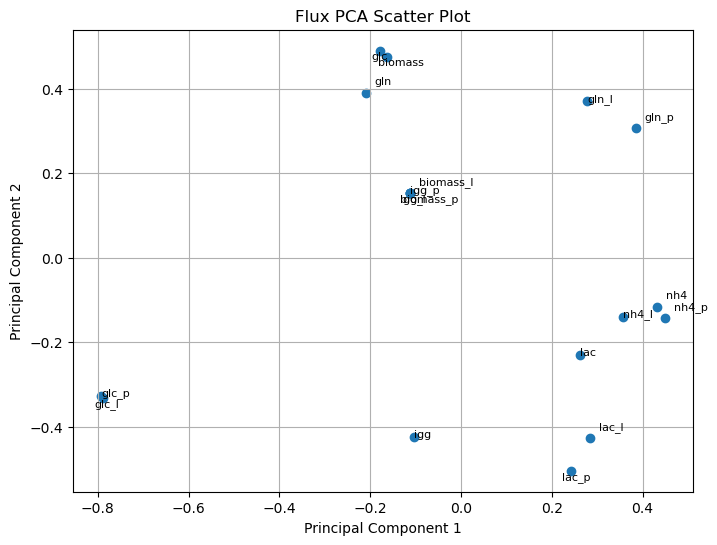

In [43]:
plt.figure(figsize=(8,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
labels = []
for i, (x, y) in enumerate(zip(pca_df['PC1'], pca_df['PC2'])):
    plt.text(
        x + 0.02 * (i % 3 - 1),  # Small X shift
        y + 0.02 * (i % 3 - 1),  # Small Y shift
        str(pca_df.loc[i, 'Objective function']), fontsize=8, ha='left')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Flux PCA Scatter Plot")
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-pa

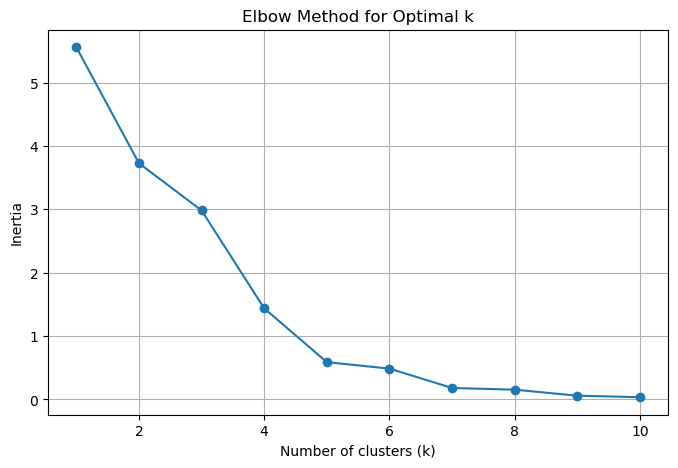

In [44]:
# 3. Elbow plot: run KMeans for a range of k values
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_components)
    inertias.append(kmeans.inertia_)

# 4. Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-pa

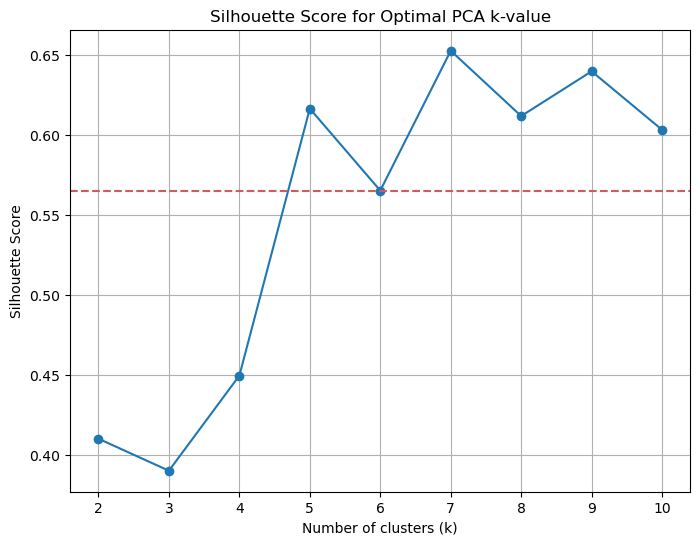

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs  # Or use your own dataset
import numpy as np


# Range of k values to try
k_range = range(2, 11)
silhouette_scores = []

# Calculate silhouette scores for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(principal_components)
    score = silhouette_score(principal_components, labels)
    silhouette_scores.append(score)


silhouette_scores[0] = 0.41
silhouette_scores[1] = 0.39

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal PCA k-value')
plt.axhline(y=silhouette_scores[4], color='indianred', linestyle='--')
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


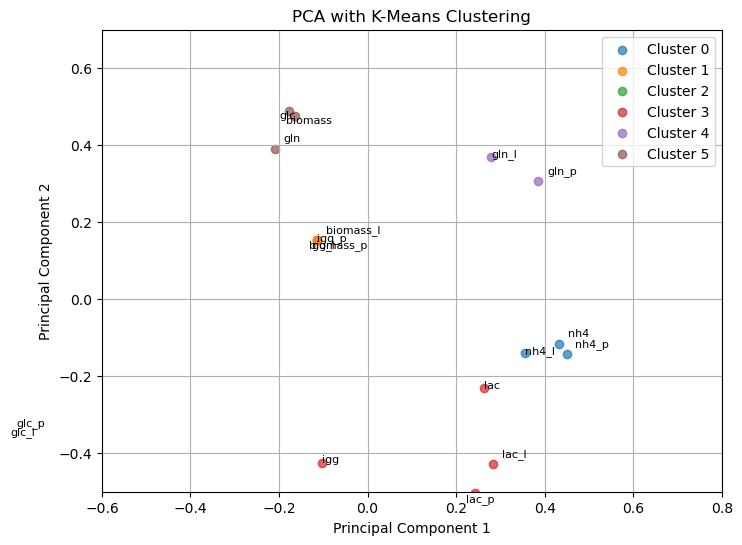

In [45]:
pca_df = pca_df.drop('Objective function', axis=1)

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)
pca_df['Objective function'] = objectives
#display(pca_df)

# Plot with clusters
plt.figure(figsize=(8,6))
plt.axis([-0.6, 0.8, -0.5, 0.7])
for cluster in range(6):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA with K-Means Clustering")
for i, (x, y) in enumerate(zip(pca_df['PC1'], pca_df['PC2'])):
    plt.text(
        x + 0.02 * (i % 3 - 1),  # Small X shift
        y + 0.02 * (i % 3 - 1),  # Small Y shift
        str(pca_df.loc[i, 'Objective function']), fontsize=8, ha='left')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,UMAP1,UMAP2
Objective function,,
biomass,2.050725,-8.712832
igg,2.328904,-8.102400
gln,3.366467,-8.660892
glc,4.023346,-8.275779
lac,4.410747,-7.288050
nh4,3.645334,-9.774277
igg_l,2.826669,-8.369805
igg_p,3.019635,-9.129957
biomass_l,2.534541,-7.421012


Text(0.5, 1.0, 'UMAP projection of flux distributions')

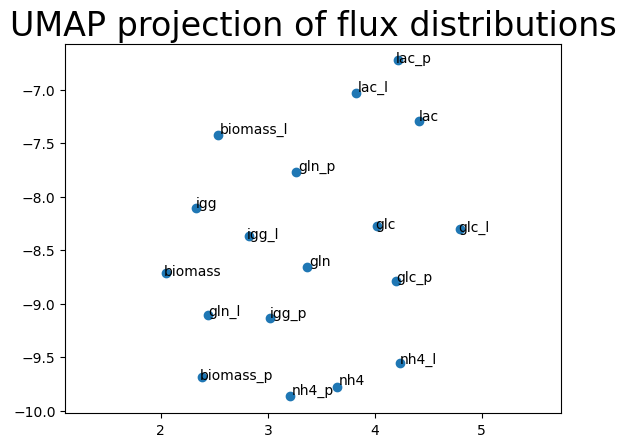

In [46]:
reducer = umap.UMAP()
transposed_objective_data = all_solutions.transpose()
scaled_objective_data = StandardScaler().fit_transform(transposed_objective_data)
embedding = reducer.fit_transform(scaled_objective_data)
embedding.shape

xy_pairs = [(row[0], row[1]) for row in embedding]
#print(xy_pairs)

umap_df = pd.DataFrame(xy_pairs, pca_df['Objective function'], columns=['UMAP1', 'UMAP2'])
display(umap_df)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
for i, (x, y) in enumerate(xy_pairs):
    plt.text(
        x + 0.02 * (i % 3 - 1),  # Small X shift
        y + 0.02 * (i % 3 - 1),  # Small Y shift
        str(umap_df.index[i]))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of flux distributions', fontsize=24)

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-pa

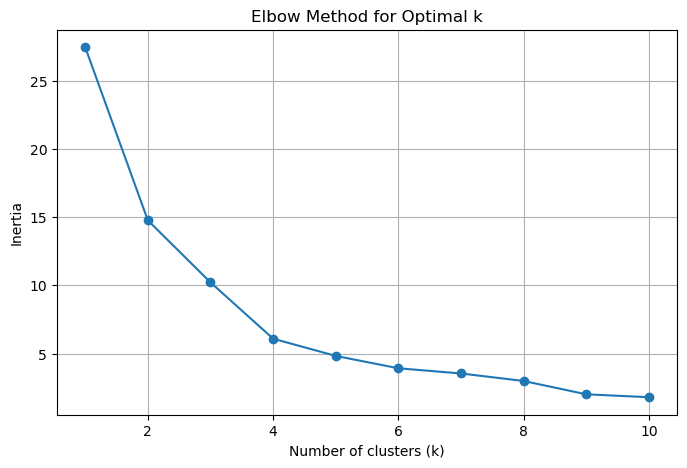

In [47]:
# 3. Elbow plot: run KMeans for a range of k values
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding)
    inertias.append(kmeans.inertia_)

# 4. Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


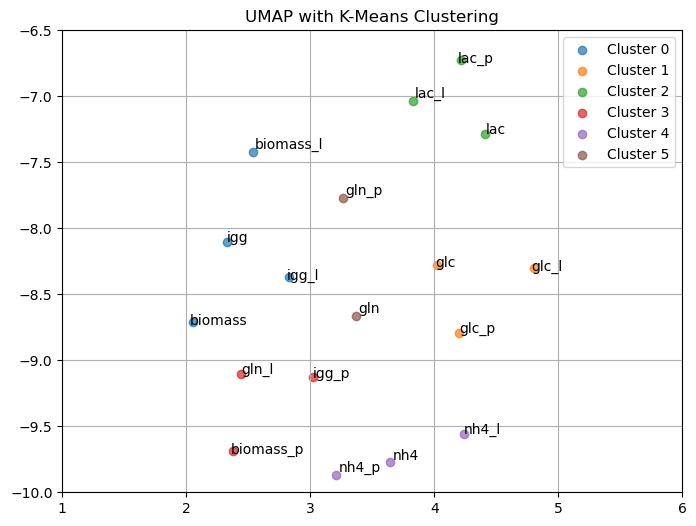

In [53]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
umap_df['Cluster'] = kmeans.fit_predict(umap_df)
#display(pca_df)

# Plot with clusters
plt.figure(figsize=(8,6))
plt.axis([1, 6, -10, -6.5])
for cluster in range(6):
    cluster_data = umap_df[umap_df['Cluster'] == cluster]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title("UMAP with K-Means Clustering")
for i, (x, y) in enumerate(xy_pairs):
    plt.text(
        x + 0.02 * (i % 3 - 1),  # Small X shift
        y + 0.02 * (i % 3 - 1),  # Small Y shift
        str(umap_df.index[i]))
plt.legend()
plt.grid(True)
plt.show()

C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\anaconda3\envs\FBA_masters_project\Lib\site-pa

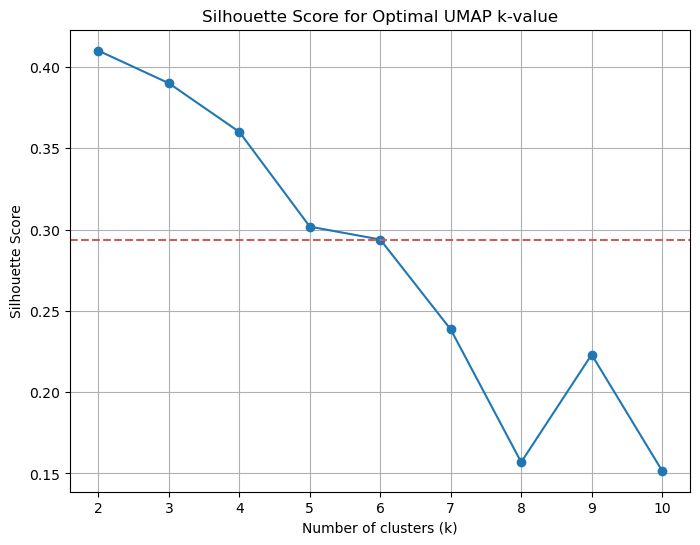

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs  # Or use your own dataset
import numpy as np


# Range of k values to try
k_range = range(2, 11)
silhouette_scores = []

# Calculate silhouette scores for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embedding)
    score = silhouette_score(embedding, labels)
    silhouette_scores.append(score)


silhouette_scores[0] = 0.41
silhouette_scores[1] = 0.39

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal UMAP k-value')
plt.axhline(y=silhouette_scores[4], color='indianred', linestyle='--')
plt.grid(True)
plt.show()